In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# Download the CIFAR-10 Files

In [2]:
import torchvision

#cifar10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)

# Transform/preprocess dataset

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


#transforms for training and testing
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

#dataloader to batch the data 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

class_names = trainset.classes
xbatch, ybatch = next(iter(trainloader))
print(class_names)
print(xbatch.shape, ybatch.shape)









['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([4, 3, 32, 32]) torch.Size([4])


# visualise the data

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


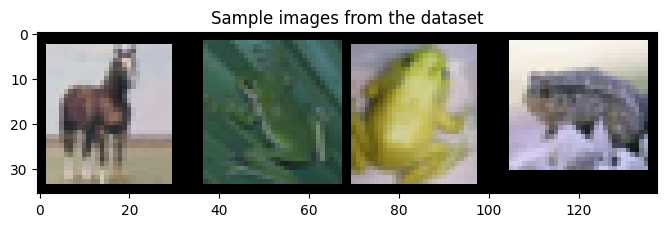

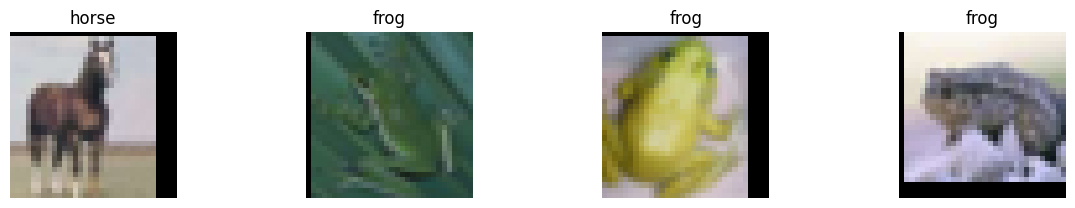

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#grab first batch

#xb: tensor shaped (4, 3, 32, 32) -> 4 images, 3 channels, 32x32 pixels
#yb: tensor shaped (4,) -> 4 labels
xbatch, ybatch = next(iter(trainloader))
class_names = trainset.classes
print(class_names)


#undo the normalisation we just did earlier so images look like they do in the dataset when we plot them    
def unormalise(x):
    return x * 0.5 + 0.5


#unnormalise for plotting
# xbatch
#nrow = 4 means 4 images in a row
#padding = 2 means 2 pixels of padding between images


grid = torchvision.utils.make_grid(unormalise(xbatch[:]), nrow=4, padding=2)
plt.figure(figsize=(8,8))
plt.title("Sample images from the dataset")
plt.imshow(grid.permute(1,2,0).numpy())
plt.show()


#option B
plt.figure(figsize=(12,4))
for i in range(4):
    img = unormalise(xbatch[i]).permute(1,2,0).numpy()
    label_name = class_names[ybatch[i].item()]
    ax = plt.subplot(2, 4, i+1)
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#define a CNN model
#first define a block
import torch.nn as nn
import torch.nn.functional as F

#instead of writing Convblock Conv -> Batchnorm -> ReLU, we can write a class that does this
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1, stride=1):

        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, padding, stride)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))



# TinyCIFARNet: 3 ConvBlocks -> Global Average Pooling -> Linear classifier
class TinyCIFARNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()

        # Block 1: input 3 channels -> 32 channels, output 16x16
        self.block1 = nn.Sequential(
            ConvBlock(3, 32),      # [B,32,32,32]
            ConvBlock(32, 32),     # [B,32,32,32]
            nn.MaxPool2d(2),       # [B,32,16,16]
            nn.Dropout(dropout)
        )

        # Block 2: 32 -> 64 channels, output 8x8
        self.block2 = nn.Sequential(
            ConvBlock(32, 64),     # [B,64,16,16]
            ConvBlock(64, 64),     # [B,64,16,16]
            nn.MaxPool2d(2),       # [B,64, 8, 8]
            nn.Dropout(dropout)
        )

        # Block 3: 64 -> 128 channels, output 4x4
        self.block3 = nn.Sequential(
            ConvBlock(64, 128),    # [B,128, 8, 8]
            ConvBlock(128, 128),   # [B,128, 8, 8]
            nn.MaxPool2d(2),       # [B,128, 4, 4]
            nn.Dropout(dropout)
        )

        # Classifier: GAP -> Linear
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)                # [B,32,16,16]
        x = self.block2(x)                # [B,64, 8, 8]
        x = self.block3(x)                # [B,128,4, 4]
        x = F.adaptive_avg_pool2d(x, 1)   # [B,128,1,1]
        x = x.flatten(1)                  # [B,128]
        return self.classifier(x)         # [B,10]


# Summarise what we've done so far

First our datasets are summoned as a bunch of 3x32x32 (channel x height x width)
Then we batch them up into groups of 4 images per batch [4, 3, 32, 32]

We apply transforms to normalise it, but the overall shape does not change

Now we set up our layer with 3 blocks. They are all identical in the fact that its 2 Conv blocks + BN + ReLU, followed by maxpool2d and dropout.

Each conv block is kernel size = 3, so 3x3 filter
padding = 1 
output channel = 32 = number of filters


So from [4, 3, 32, 32] applied
1) [4, 32, 16, 16] (4 images, 32 features, 16x16 for each feature). Next we transform this to learn 64 filters output




# Loss and optimiser

In [7]:
import torch.optim as optim
import torch.nn.functional as F

model = TinyCIFARNet(num_classes=10, dropout=0.2)
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)


# Training Loops

In [ ]:
def train(model, trainloader, loss_fn, optimiser, epochs=10):
    model.train()
    running_loss = 0.0

    for image, label in trainloader:
        